In [ ]:
import nltk

from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk import ngrams

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import csv

In [ ]:
# Just for Google Colab Users
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
!pip install langid
!pip install pyLDAvis

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 7.5 MB/s 
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941188 sha256=e66de5aa42ca5c8cfa9d6424da70d916ec9004b878b7348883c947b6fb53087a
  Stored in directory: /root/.cache/pip/wheels/2b/bb/7f/11e4db39477278161e882eadc46fb558949a28b13470fc74b8
Successfully built langid
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 7.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel 

In [ ]:
df = pd.read_csv('DrugReviews.csv')
df

uniqueID                  drugName                     condition  \
0         206461                 Valsartan  Left Ventricular Dysfunction   
1          95260                Guanfacine                          ADHD   
2          92703                    Lybrel                 Birth Control   
3         138000                Ortho Evra                 Birth Control   
4          35696  Buprenorphine / naloxone             Opiate Dependence   
...          ...                       ...                           ...   
215058    159999                 Tamoxifen     Breast Cancer, Prevention   
215059    140714              Escitalopram                       Anxiety   
215060    130945            Levonorgestrel                 Birth Control   
215061     47656                Tapentadol                          Pain   
215062    113712                 Arthrotec                      Sciatica   

                                                   review  rating       date  \
0       "It has no side effect, I take it in combinati...       9  20-May-12   
1       "My son is halfway through his fourth week of ...       8  27-Apr-10   
2       "I used to take another oral contraceptive, wh...       5  14-Dec-09   
3       "This is my first time using any form of birth...       8   3-Nov-15   
4       "Suboxone has completely turned my life around...       9  27-Nov-16   
...                                                   ...     ...        ...   
215058  "I have taken Tamoxifen for 5 years. Side effe...      10  13-Sep-14   
215059  "I&#039;ve been taking Lexapro (escitaploprgra...       9   8-Oct-16   
215060  "I&#039;m married, 34 years old and I have no ...       8  15-Nov-10   
215061  "I was prescribed Nucynta for severe neck/shou...       1  28-Nov-11   
215062                                      "It works!!!"       9  13-Sep-09   

        usefulCount  
0                27  
1               192  
2                17  
3                10  
4                37  
...             ...  
215058           43  
215059           11  
215060            7  
215061           20  
215062           46  

[215063 rows x 7 columns]

In [ ]:
# outputting some rows that aren't conditions (likely noise that accidentally got put into data)
# going to remove all the rows w "users found this comment helpful"
df['condition'].array.unique()

<PandasArray>
[                'Left Ventricular Dysfunction',
                                         'ADHD',
                                'Birth Control',
                            'Opiate Dependence',
                 'Benign Prostatic Hyperplasia',
                      'Emergency Contraception',
                              'Bipolar Disorde',
                                     'Epilepsy',
                          'Migraine Prevention',
                                   'Depression',
 ...
     'Lyme Disease, Erythema Chronicum Migrans',
 '100</span> users found this comment helpful.',
                       'Renal Tubular Acidosis',
                     'Yellow Fever Prophylaxis',
                         'Acute Otitis Externa',
   'Steroid Responsive Inflammatory Conditions',
 '135</span> users found this comment helpful.',
  '38</span> users found this comment helpful.',
                        'Pertussis Prophylaxis',
 '105</span> users found this comment helpful.']
L

In [ ]:
# removed 2365 rows, meaning lots of noise entered the dataframe
no_noise_df = df[df['condition'].str.contains('users found this comment')==False]
no_noise_df

uniqueID                  drugName                     condition  \
0         206461                 Valsartan  Left Ventricular Dysfunction   
1          95260                Guanfacine                          ADHD   
2          92703                    Lybrel                 Birth Control   
3         138000                Ortho Evra                 Birth Control   
4          35696  Buprenorphine / naloxone             Opiate Dependence   
...          ...                       ...                           ...   
215058    159999                 Tamoxifen     Breast Cancer, Prevention   
215059    140714              Escitalopram                       Anxiety   
215060    130945            Levonorgestrel                 Birth Control   
215061     47656                Tapentadol                          Pain   
215062    113712                 Arthrotec                      Sciatica   

                                                   review  rating       date  \
0       "It has no side effect, I take it in combinati...       9  20-May-12   
1       "My son is halfway through his fourth week of ...       8  27-Apr-10   
2       "I used to take another oral contraceptive, wh...       5  14-Dec-09   
3       "This is my first time using any form of birth...       8   3-Nov-15   
4       "Suboxone has completely turned my life around...       9  27-Nov-16   
...                                                   ...     ...        ...   
215058  "I have taken Tamoxifen for 5 years. Side effe...      10  13-Sep-14   
215059  "I&#039;ve been taking Lexapro (escitaploprgra...       9   8-Oct-16   
215060  "I&#039;m married, 34 years old and I have no ...       8  15-Nov-10   
215061  "I was prescribed Nucynta for severe neck/shou...       1  28-Nov-11   
215062                                      "It works!!!"       9  13-Sep-09   

        usefulCount  
0                27  
1               192  
2                17  
3                10  
4                37  
...             ...  
215058           43  
215059           11  
215060            7  
215061           20  
215062           46  

[212698 rows x 7 columns]

In [ ]:
# number of reviews for each condition
no_noise_df['condition'].value_counts()

Birth Control                                              38436
Depression                                                 12164
Pain                                                        8245
Anxiety                                                     7812
Acne                                                        7435
                                                           ...  
Amyotrophic Lateral Sclerosis                                  1
Hyperlipoproteinemia Type III, Elevated beta-VLDL   IDL        1
Hydrocephalus                                                  1
Legionella Pneumonia                                           1
Pertussis Prophylaxis                                          1
Name: condition, Length: 836, dtype: int64

In [ ]:
# removed 81 unique rows
no_noise_df['condition'].array.unique()

<PandasArray>
[              'Left Ventricular Dysfunction',
                                       'ADHD',
                              'Birth Control',
                          'Opiate Dependence',
               'Benign Prostatic Hyperplasia',
                    'Emergency Contraception',
                            'Bipolar Disorde',
                                   'Epilepsy',
                        'Migraine Prevention',
                                 'Depression',
 ...
                      'Occupational Exposure',
        'Tympanostomy Tube Placement Surgery',
                            'Pulmonary Edema',
                       'Mantle Cell Lymphoma',
   'Lyme Disease, Erythema Chronicum Migrans',
                     'Renal Tubular Acidosis',
                   'Yellow Fever Prophylaxis',
                       'Acute Otitis Externa',
 'Steroid Responsive Inflammatory Conditions',
                      'Pertussis Prophylaxis']
Length: 836, dtype: object

# Anxiety

In [ ]:
anxiety = df[(df['condition']=='Anxiety')]
anxiety

uniqueID      drugName condition  \
60        131704    Effexor XR   Anxiety   
107       163567   Mirtazapine   Anxiety   
114       160750     Buspirone   Anxiety   
115        65646   Propranolol   Anxiety   
193       147353    Alprazolam   Anxiety   
...          ...           ...       ...   
214973     22899      Tranxene   Anxiety   
214983    147131    Alprazolam   Anxiety   
215032    184342   Hydroxyzine   Anxiety   
215050    204390        BuSpar   Anxiety   
215059    140714  Escitalopram   Anxiety   

                                                   review  rating       date  \
60      "Was on this med for 5 years. Worked fine but ...       6  27-Dec-16   
107     "I used it at bed time along with Paxil. I hav...       8  17-Mar-15   
114     "Have tried Paxil and Lexapro which sent me in...       9  12-Mar-11   
115     "I have been suffering with this anxiety probl...      10   8-Apr-17   
193     "Changed my life completely, I can actually fu...      10  28-Oct-11   
...                                                   ...     ...        ...   
214973  "Traxene is one of the older medicines.  I lik...      10  23-Jul-13   
214983  "I was in car accident, brain damage, 10 years...      10  20-Jan-14   
215032  "I have a rare disease called Systemic Mastocy...      10  26-Mar-15   
215050  "Diagnosed with general anxiety disorder.  Wou...      10  25-Feb-16   
215059  "I&#039;ve been taking Lexapro (escitaploprgra...       9   8-Oct-16   

        usefulCount  
60               23  
107              72  
114               9  
115              40  
193               4  
...             ...  
214973          125  
214983           51  
215032           26  
215050          123  
215059           11  

[7812 rows x 7 columns]

In [ ]:
len(anxiety)

7812

In [ ]:
anxiety.shape

(7812, 7)

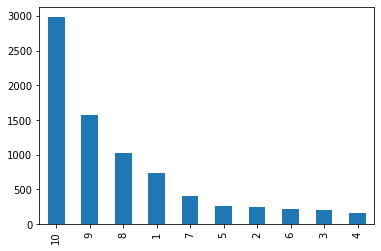

In [ ]:
rating_anxiety = pd.Series(anxiety['rating'])

review_anxiety = rating_anxiety.value_counts()

# review ratings shown from greatest to least
review_anxiety.plot(kind='bar')

## Sentiment Analysis

In [ ]:
conditions = [
    (anxiety['rating'] <= 4),
    (anxiety['rating'] == 5) | (anxiety['rating'] == 6),
    (anxiety['rating'] >= 7),
    ]

# create a list of the values we want to assign for each condition
values = ['Negative', 'Neutral', 'Positive']

# create a new column and use np.select to assign values to it using our lists as arguments
anxiety['Sentiment'] = np.select(conditions, values)

# display updated DataFrame
anxiety.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


uniqueID     drugName condition  \
60     131704   Effexor XR   Anxiety   
107    163567  Mirtazapine   Anxiety   
114    160750    Buspirone   Anxiety   
115     65646  Propranolol   Anxiety   
193    147353   Alprazolam   Anxiety   

                                                review  rating       date  \
60   "Was on this med for 5 years. Worked fine but ...       6  27-Dec-16   
107  "I used it at bed time along with Paxil. I hav...       8  17-Mar-15   
114  "Have tried Paxil and Lexapro which sent me in...       9  12-Mar-11   
115  "I have been suffering with this anxiety probl...      10   8-Apr-17   
193  "Changed my life completely, I can actually fu...      10  28-Oct-11   

     usefulCount Sentiment  
60            23   Neutral  
107           72  Positive  
114            9  Positive  
115           40  Positive  
193            4  Positive

In [ ]:
# no missing reviews for any of the drugs for anxiety, so we don't need to drop any rows
# this also tells us that there are 7812 reviews from people taking anxiety medication
anxiety['review'].isna().value_counts()

False    7812
Name: review, dtype: int64

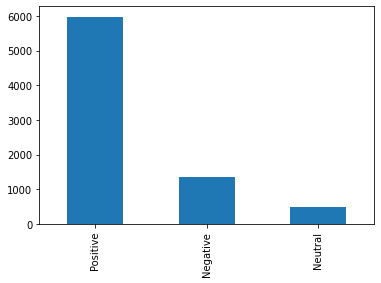

In [ ]:
# predominantly positive reviews for anxiety medication
anxiety_sentiment = pd.Series(anxiety['Sentiment'])

anx_sentiment_count = anxiety_sentiment.value_counts()

anx_sentiment_count.plot(kind='bar')

In [ ]:
# find unique values: https://www.statology.org/pandas-unique-values-in-column/

# all the anxiety medication used by people with anxiety
anx_drugs = anxiety['drugName'].array.unique()
anx_drugs = pd.DataFrame(anx_drugs)
anx_drugs

0
0              Effexor XR
1             Mirtazapine
2               Buspirone
3             Propranolol
4              Alprazolam
..                    ...
76                Nadolol
77               Dilantin
78                   Kava
79                 Hyzine
80  Aspirin / meprobamate

[81 rows x 1 columns]

In [ ]:
# anxiety medication that got positive reviews
high_anx_review = anxiety[(anxiety['Sentiment']=='Positive')]
array_high_anx_review = high_anx_review['drugName'].array.unique()
unique_high_anx_review = pd.DataFrame(array_high_anx_review)
unique_high_anx_review

0
0             Mirtazapine
1               Buspirone
2             Propranolol
3              Alprazolam
4            Escitalopram
..                    ...
74            Tranxene SD
75               Dilantin
76                   Kava
77  Aspirin / meprobamate
78                Nadolol

[79 rows x 1 columns]

In [ ]:
# number of reviews for each brand used to treat anxiety, sorted from greatest number of reviews to least
anxiety['drugName'].value_counts()

Escitalopram             669
Alprazolam               560
Buspirone                538
Clonazepam               528
Lexapro                  483
                        ... 
Micrainin                  1
Zetran                     1
Serzone                    1
Hyzine                     1
Aspirin / meprobamate      1
Name: drugName, Length: 81, dtype: int64

In [ ]:
# compared highly reviewed anxiety medications vs all the anxiety medications, where Vanspar and Hyzine
# are the only two out of 81 brands of medication that didn't get "Positive" scores, meaning they had ratings < 7 
pd.concat([anx_drugs,unique_high_anx_review]).drop_duplicates(keep=False)

0
59  Vanspar
79   Hyzine

In [ ]:
# two total reviews from anxiety patients using Vanspar, who both left negative reviews
vanspar=anxiety[(anxiety['drugName']=='Vanspar')]
vanspar

uniqueID drugName condition  \
32622     219137  Vanspar   Anxiety   
194583    219138  Vanspar   Anxiety   

                                                   review  rating       date  \
32622   "Went into anaphylaxis after third dose. Incre...       1  14-Jan-17   
194583  "It has made me irritable, socially awkward, h...       2   9-Apr-15   

        usefulCount Sentiment  
32622            10  Negative  
194583           21  Negative

In [ ]:
# one patient having used Hyzine for anxiety medication, who gave a negative review
hyzine=anxiety[(anxiety['drugName']=='Hyzine')]
hyzine

uniqueID drugName condition  \
169085    195182   Hyzine   Anxiety   

                                                   review  rating       date  \
169085  "I took it like I was supposed to for anxiety ...       1  12-Nov-16   

        usefulCount Sentiment  
169085           42  Negative

In [ ]:
# I recognize that I can't say that Vanspar and Hyzine are "bad" anxiety medications because (1) the sample size is too
# small to be making those conclusions and (2) according to the sentiment chart, a lot more people left neutral/negative
# reviews on the different medications, although I'm not certain which ones have received the most neutral/negative
# reviews yet. The only thing the line of code:

# pd.concat([anx_drugs,unique_high_anx_review]).drop_duplicates(keep=False)

# demonstrates are the medications that received only neutral/negative reviews, meaning if a brand averages having poor
# ratings, but got even one positive review, it'd be excluded from this table. I'd like to use this table to take a
# closer look at them (ie. are they over-the-counter? What are some negative side effects people get from these brands,
# and are they common side effects?). I also recognize that this line of code is flawed because the brands with fewer
# reviews are more likely to show up on this table (and it shows in the output, since the two brands that made it on 
# the table only have 1-2 reviews). This line of code may be a better way of seeing which brands are trying to
# break into making anxiety medication or are used to treat multiple things at once (ie. headaches, chills, and anxiety)
# and therefore is less effective.

# However, by observing the reviews these brands got from people who've been prescribed them, they receive a lot of
# valuable information from people who use them (especially since for medication, how does anyone know if they're
# effective unless people use them?). Although we can't draw any conclusions from this line of code, the two brands
# (Vanspar & Hyzine) have a lot to gain from trying to see how they can better help treat anxiety or try to turn 
# these very upset customers into loyal ones.

In [ ]:
# brands with the most to least total neutral/negative reviews
anx_neutral_negative=anxiety[(anxiety['Sentiment']=='Neutral') | (anxiety['Sentiment']=='Negative')] 
anx_neutral_negative['drugName'].value_counts()

Buspirone           221
Hydroxyzine         194
Escitalopram        150
BuSpar              123
Lexapro             100
Lorazepam            72
Clonazepam           65
Mirtazapine          61
Venlafaxine          60
Paroxetine           57
Alprazolam           57
Duloxetine           55
Vistaril             54
Cymbalta             49
Paxil                48
Gabapentin           46
Xanax                43
Ativan               40
Effexor XR           37
Klonopin             30
Desvenlafaxine       30
Atarax               26
Diazepam             26
Bupropion            25
Propranolol          25
Pristiq              24
Trazodone            13
Risperidone          11
Valium                9
Vilazodone            9
Clonidine             7
Lamotrigine           7
Remeron               6
Oxcarbazepine         6
Doxepin               5
Atenolol              5
Prochlorperazine      4
Xanax XR              4
Chlordiazepoxide      4
Compazine             3
Librium               3
Vanspar         

In [ ]:
from sklearn.model_selection import train_test_split

X = anxiety['review']
y = anxiety['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

In [ ]:
X_train.head(10)

26852     "This is my third round of starting Pristiq (0...
166074    "I believe this medication saved my life. I di...
163380    "Most subtle of the benzos i have tried.  Made...
194139    "Went on Effexor for panic disorder/social anx...
61732     "Xanax made me crazy. I am now in the process ...
152890    "This is my second time taking Paxil. For me, ...
83400     "Am able to drive around town way better, but ...
33606     "Honestly, a very good drug for anxiety and de...
136866    "I have bad anxiety about medicines. The only ...
25657     "I have been on Paxil for about 6 years now an...
Name: review, dtype: object

In [ ]:
# code borrowed from Text Mining v.2.ipynb
tokenizer = nltk.RegexpTokenizer(r'[a-zA-Z]{3,}')

count_vect = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1), tokenizer=tokenizer.tokenize)
X_train_converted = count_vect.fit_transform(X_train)
X_test_converted = count_vect.transform(X_test)

X_train_converted_df = pd.DataFrame(X_train_converted.toarray(), columns = count_vect.get_feature_names_out())
X_train_converted_df.head(10)

aad  abandoned  abandonment  abate  abdomen  abdominal  abilify  abilities  \
0    0          0            0      0        0          0        0          0   
1    0          0            0      0        0          0        0          0   
2    0          0            0      0        0          0        0          0   
3    0          0            0      0        0          0        0          0   
4    0          0            0      0        0          0        0          0   
5    0          0            0      0        0          0        0          0   
6    0          0            0      0        0          0        0          0   
7    0          0            0      0        0          0        0          0   
8    0          0            0      0        0          0        0          0   
9    0          0            0      0        0          0        0          0   

   ability  able  ...  zone  zoned  zoning  zonked  zonks  zopiclone  zyban  \
0        0     0  ...     0      0       0       0      0          0      0   
1        0     0  ...     0      0       0       0      0          0      0   
2        0     0  ...     0      0       0       0      0          0      0   
3        1     0  ...     0      0       0       0      0          0      0   
4        0     0  ...     0      0       0       0      0          0      0   
5        0     0  ...     0      0       0       0      0          0      0   
6        0     1  ...     0      0       0       0      0          0      0   
7        0     0  ...     0      0       0       0      0          0      0   
8        0     0  ...     0      0       0       0      0          0      0   
9        0     0  ...     0      0       0       0      0          0      0   

   zyprexa  zyrtec  zzzquil  
0        0       0        0  
1        0       0        0  
2        0       0        0  
3        0       0        0  
4        0       0        0  
5        0       0        0  
6        0       0        0  
7        0       0        0  
8        0       0        0  
9        0       0        0  

[10 rows x 8262 columns]

In [ ]:
corpus = anxiety['review'].array
tfidf_vect = TfidfVectorizer(tokenizer = tokenizer.tokenize, stop_words='english', ngram_range = (1,1))
TF_IDF = tfidf_vect.fit_transform(corpus)
TF_IDF_df = pd.DataFrame(TF_IDF.toarray(), columns = tfidf_vect.get_feature_names_out())
TF_IDF_df

aad  abandoned  abandonment  abate  abdomen  abdominal  abilify  \
0     0.0        0.0          0.0    0.0      0.0        0.0      0.0   
1     0.0        0.0          0.0    0.0      0.0        0.0      0.0   
2     0.0        0.0          0.0    0.0      0.0        0.0      0.0   
3     0.0        0.0          0.0    0.0      0.0        0.0      0.0   
4     0.0        0.0          0.0    0.0      0.0        0.0      0.0   
...   ...        ...          ...    ...      ...        ...      ...   
7807  0.0        0.0          0.0    0.0      0.0        0.0      0.0   
7808  0.0        0.0          0.0    0.0      0.0        0.0      0.0   
7809  0.0        0.0          0.0    0.0      0.0        0.0      0.0   
7810  0.0        0.0          0.0    0.0      0.0        0.0      0.0   
7811  0.0        0.0          0.0    0.0      0.0        0.0      0.0   

      abilities  ability  ablation  ...  zoned  zoning  zonk  zonked  zonks  \
0           0.0      0.0       0.0  ...    0.0     0.0   0.0     0.0    0.0   
1           0.0      0.0       0.0  ...    0.0     0.0   0.0     0.0    0.0   
2           0.0      0.0       0.0  ...    0.0     0.0   0.0     0.0    0.0   
3           0.0      0.0       0.0  ...    0.0     0.0   0.0     0.0    0.0   
4           0.0      0.0       0.0  ...    0.0     0.0   0.0     0.0    0.0   
...         ...      ...       ...  ...    ...     ...   ...     ...    ...   
7807        0.0      0.0       0.0  ...    0.0     0.0   0.0     0.0    0.0   
7808        0.0      0.0       0.0  ...    0.0     0.0   0.0     0.0    0.0   
7809        0.0      0.0       0.0  ...    0.0     0.0   0.0     0.0    0.0   
7810        0.0      0.0       0.0  ...    0.0     0.0   0.0     0.0    0.0   
7811        0.0      0.0       0.0  ...    0.0     0.0   0.0     0.0    0.0   

      zopiclone  zyban  zyprexa  zyrtec  zzzquil  
0           0.0    0.0      0.0     0.0      0.0  
1           0.0    0.0      0.0     0.0      0.0  
2           0.0    0.0      0.0     0.0      0.0  
3           0.0    0.0      0.0     0.0      0.0  
4           0.0    0.0      0.0     0.0      0.0  
...         ...    ...      ...     ...      ...  
7807        0.0    0.0      0.0     0.0      0.0  
7808        0.0    0.0      0.0     0.0      0.0  
7809        0.0    0.0      0.0     0.0      0.0  
7810        0.0    0.0      0.0     0.0      0.0  
7811        0.0    0.0      0.0     0.0      0.0  

[7812 rows x 9132 columns]

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

decision_tree_model = DecisionTreeClassifier(criterion='gini', max_depth=15)
decision_tree_model.fit(X_train_converted, y_train)

predicted= decision_tree_model.predict(X_test_converted)
print("Decision Tree Accuracy:", str(round(metrics.accuracy_score(y_test, predicted)*100,2))+"%")

Decision Tree Accuracy: 79.78%


In [ ]:
from sklearn.tree import export_text
tree_rules = export_text(decision_tree_model, feature_names=count_vect.get_feature_names())
print(tree_rules)

|--- life <= 0.50
|   |--- worse <= 0.50
|   |   |--- horrible <= 0.50
|   |   |   |--- didn <= 0.50
|   |   |   |   |--- did <= 0.50
|   |   |   |   |   |--- later <= 0.50
|   |   |   |   |   |   |--- great <= 0.50
|   |   |   |   |   |   |   |--- dizzy <= 0.50
|   |   |   |   |   |   |   |   |--- advise <= 0.50
|   |   |   |   |   |   |   |   |   |--- luckily <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- bizarre <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |   |--- bizarre >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: Negative
|   |   |   |   |   |   |   |   |   |--- luckily >  0.50
|   |   |   |   |   |   |   |   |   |   |--- having <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- having >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: Neutral
|   |   |   |   |   |   |   |   |--- advise > 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# It seems when people use words like: "bizarre", "irritable", "panic", "leave" "dosages", "continued", "unfortunately",
# and "advise" people were typically not happy because they left negative reviews. This is likely that people thought 
# it was bizarre that the anxiety medication wasn't working for them, even after they were prescribed a higher dosage. 
# They likely continued experiencing their symptoms before receiving medication and unfortunately continued having 
# panic attacks and experienced side effects, like irritability. Some customers may have decided that it was better 
# to stay off medication and leave their anxiety as it is, since the medication wasn't helping, and advised other people
# to do the same. It's possible that these patients were discussing certain brands to avoid or anxiety medication as a
# whole. Given the amount of sentiment analysis I did, I am unable to draw conclusions about either, but I can infer
# based on the verbage of people who left negative reviews.

# When people used "dizzy", "night", "tapering", "hours", "elevated", "cold", and "felt", they seemed to feel impartial
# about the medication, as they left neutral reviews. There were a mix of words that appeared in reviews where people 
# were either happy or sad about the medication (ie. unhappy = "worst", "personal"; happy = "helped", "medicine"). On
# the negative end of the spectrum, that may have been my fault, because I think the range I put for neutral may have
# been a little too large. Personally, I think rating 4-6 for neutral is a little wide, but I wanted the distribution
# of the rating numbers to be as equal as possible. So admittedly, some of the overlap between neutral and negative
# might actually be words that should coming from unsatisfied customers. As for the ones with overlap with happy customers,
# it's possible that the medication had some positive effect and alleviated some symptoms, but maybe it wasn't enough to
# relieve the anxiety patients from their most bothersome symptoms.

# Based on the verbage of people who left neutral reviews, it seems like people discussed some side effects, like feeling 
# cold or dizzy. It's possible that they felt that it took a little too long for the medication to kick in, or wore off
# sooner than it should.

# When people used words like "nausea", "great", "completely", "sluggish", "overwhelming", and "daily", they tended
# to be happy with their medication, thus leaving positive reviews. Words like "nausea", "sluggish", and "overwhelming"
# may seem like negative words out of context, but since they were associated with happy customers, it's likely that
# these customers are discussing symptoms they had that were alleviated by the medication, meaning they no longer feel
# as much nausea, rarely feel sluggish, and tasks don't feel as overwhelming as before. It seems like they use their
# medication on a daily basis to live anziety-free.

## Topic Modeling

In [ ]:
all_anxiety_reviews = " ".join(review for review in anxiety['review'])
all_anxiety_reviews

'"Was on this med for 5 years. Worked fine but not great. Stopped the panic attacks and gave me relief of every day nervousness that I was experiencing. Took months for the side effects to diminish when I first started taking it. What did not leave - insomnia, night sweats, lack of sex drive and poor orgasms (or no orgasms at all)." "I used it at bed time along with Paxil. I have anxiety and at times insomnia. The lower the dose(@ 7.5 mg), the more it becomes a sleep aid. It worked well for both anxiety and insomnia." "Have tried Paxil and Lexapro which sent me into hyper-panic and GAD. I was about to give up on medicines and accept my miserable anxiety as a fact of life when my Doctor recommended Buspirone. I noticed my anxiety began to taper the second day I took the medication. No real side effects to speak of through my first week. The one thing it has delivered for me, HOPE!" "I have been suffering with this anxiety problem for years and it was starting to interfere with my life. 

In [ ]:
corpus = anxiety['review'].array

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


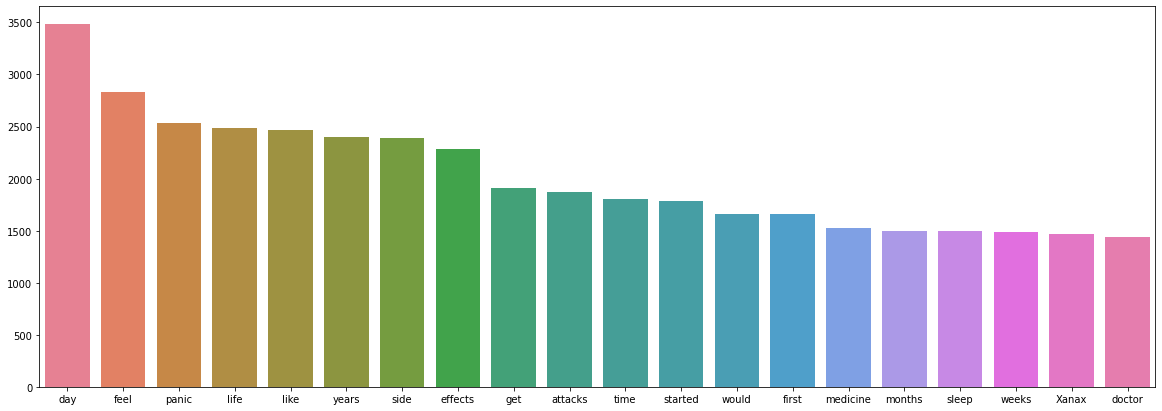

In [ ]:
import seaborn as sb

tokenizer = nltk.RegexpTokenizer(r'[a-zA-Z]{3,}')
tokens = tokenizer.tokenize(all_anxiety_reviews) 
stopwordsList = stopwords.words('english')
stopwordsList.append('anxiety')  # we're looking at anxiety, so it's a given that it's being discussed
stopwordsList.append('take')    # data is about the medication people take
stopwordsList.append('taking')  # same as take, but different part of speech 
stopwordsList.append('medication')  # it's abt medication, so this word doesn't tell us much
tokens_stop = [word for word in tokens if word.lower() not in stopwordsList]
freq_dist = nltk.FreqDist(tokens_stop)
mostCommonWordList = dict(freq_dist.most_common(20))
plt.figure(figsize =(20, 7)) 
sb.barplot(list(mostCommonWordList.keys()), list(mostCommonWordList.values()), palette='husl')

# NOTE: Xanax is the second most prescribed anxiety medication (maybe being compared to the top brand, Escitalopram?)

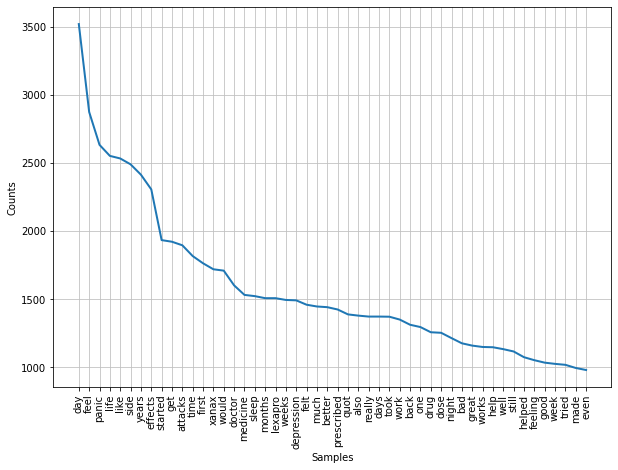

In [ ]:
freqDist = FreqDist()

for i in range (0, len(corpus)):
    reviewWordList = []
    for word in tokenizer.tokenize(corpus[i]):
        if word.lower() not in stopwordsList:
            reviewWordList.append(word.lower()) 
    
    freqDist += FreqDist(reviewWordList)
    
plt.figure(figsize =(10, 7)) 
freqDist.plot(50, cumulative=False)

In [ ]:
# Escitalopram is the anxiety medication that has the most reviews, but Xanax is the medication that's most commonly
# mentioned medication. According to the averages, Xanax's rating is roughly 1 point higher than Escitalopram on a 1-10
# point scale. Although sentiment wise, both are classified as positive, people who've taken Xanax seem to have a more
# favorable opinion about it compared to the Escitalopram users. However, it's also important to note that Escitalopram 
# has 669 reviews, while Xanax has 375 reviews, so the rating for Escitalopram is more reliable due to a larger sample 
# size, so the higher rating for Xanax should be taken with a grain of salt, but it also doesn't change the fact that
# Xanax is mentioned a lot, so it's likely that either people who take Xanax are more likely to use the name of their
# medication compared to the other people treating their anxiety, or people are comparing different brands with each 
# other, and people feel particularly good about Xanax.

# The column usefulCount is not super clear about what it's representing, thus I deduce that number represents things
# like number of side effects or time for the medication to take effect, and the higher the usefulCount, the better. 
# Thus, since Xanax has a higher usefulCount, the overall usefulness of Xanax is better than Escitalopram.  
# My conclusion might change if we include more data, but with the given dataset, Xanax might be the better option, 
# despite not being the number 1 prescribed medication. The word graph seems to support my conclusion as well, as the 
# brand most mentioned in the reviews is "Xanax," meaning people are talking about it a lot more than Escitalopram, 
# despite Escitalopram  being prescribed to more people.

anxiety[(anxiety['drugName']=='Xanax') | (anxiety['drugName']=='Escitalopram')].groupby('drugName').mean()

uniqueID    rating  usefulCount
drugName                                          
Escitalopram  146516.692078  7.825112    36.666667
Xanax           7744.578667  8.741333    46.730667

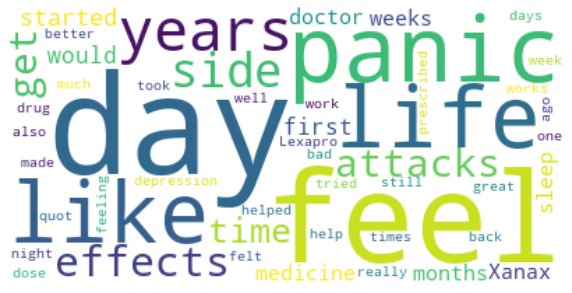

In [ ]:
from wordcloud import WordCloud

mostCommonWordList = dict(freq_dist.most_common(50))
wordcloud = WordCloud(background_color="white").generate_from_frequencies(frequencies=mostCommonWordList)

plt.figure(figsize =(10, 7)) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
tokenizer = nltk.RegexpTokenizer(r'[a-zA-Z]{3,}')

count_vect = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1), tokenizer=tokenizer.tokenize)
review_converted = count_vect.fit_transform(anxiety['review'])

review_converted_df = pd.DataFrame(review_converted.toarray(), columns = count_vect.get_feature_names_out())
review_converted_df.head(5)

aad  abandoned  abandonment  abate  abdomen  abdominal  abilify  abilities  \
0    0          0            0      0        0          0        0          0   
1    0          0            0      0        0          0        0          0   
2    0          0            0      0        0          0        0          0   
3    0          0            0      0        0          0        0          0   
4    0          0            0      0        0          0        0          0   

   ability  ablation  ...  zoned  zoning  zonk  zonked  zonks  zopiclone  \
0        0         0  ...      0       0     0       0      0          0   
1        0         0  ...      0       0     0       0      0          0   
2        0         0  ...      0       0     0       0      0          0   
3        0         0  ...      0       0     0       0      0          0   
4        0         0  ...      0       0     0       0      0          0   

   zyban  zyprexa  zyrtec  zzzquil  
0      0        0       0        0  
1      0        0       0        0  
2      0        0       0        0  
3      0        0       0        0  
4      0        0       0        0  

[5 rows x 9132 columns]

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=5, max_iter=10) #max_iter=5
lda.fit(review_converted)

LatentDirichletAllocation(n_components=5)

In [ ]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [ ]:
# can use translator package to convert to eng and interpret from there
print("Topics found via LDA:")
print_topics(lda, count_vect, 10)

Topics found via LDA:

Topic #0:
anxiety panic lexapro life weeks like attacks feel effects years

Topic #1:
day anxiety feel sleep xanax life just years like night

Topic #2:
anxiety panic xanax day attacks klonopin years works life medication

Topic #3:
anxiety taking day started effects feel felt months like weeks

Topic #4:
anxiety feel medication just like weight quot effects taking time


# ADHD

In [ ]:
adhd = df[(df['condition']=='ADHD')]
adhd

uniqueID           drugName condition  \
1          95260         Guanfacine      ADHD   
27         78563           Daytrana      ADHD   
51        135645            Intuniv      ADHD   
116        61002            Focalin      ADHD   
211        37533            Vyvanse      ADHD   
...          ...                ...       ...   
214948     88305           Adderall      ADHD   
214956     37591            Vyvanse      ADHD   
214997    191856   Lisdexamfetamine      ADHD   
215011    191724   Lisdexamfetamine      ADHD   
215053    193118  Dextroamphetamine      ADHD   

                                                   review  rating       date  \
1       "My son is halfway through his fourth week of ...       8  27-Apr-10   
27      "Hi all, My son who is 12 was diagnosed when h...      10  12-Jan-17   
51      "Intuniv did not work for my son; he was bounc...       1  21-Jul-11   
116     "My 9 year old son has been on various medicin...       9  31-Jan-10   
211     "Today was my first day taking Vyvanse and wow...       9  31-Aug-11   
...                                                   ...     ...        ...   
214948  "I was first diagnosed with ADHD at the age of...       8  22-Jun-16   
214956  "Just started taking Vyvanse. Before I was tak...      10  12-Sep-10   
214997  "I&#039;m 51-years old and was skeptical regar...      10  27-Aug-09   
215011  "I&#039;m a 22 year old male with a horrible c...       9  11-Feb-12   
215053  "Treatment for ADHD save my life. Don&#039;t b...      10  15-Nov-15   

        usefulCount  
1               192  
27               11  
51               23  
116              48  
211              11  
...             ...  
214948           65  
214956           23  
214997          129  
215011           13  
215053           36  

[4509 rows x 7 columns]

In [ ]:
len(adhd)

4509

In [ ]:
adhd.shape

(4509, 7)

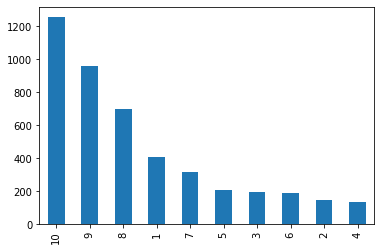

In [ ]:
rating_adhd = pd.Series(adhd['rating'])

review_adhd = rating_adhd.value_counts()

# review ratings shown from greatest to least
review_adhd.plot(kind='bar')

## Sentiment Analysis

In [ ]:
conditions = [
    (adhd['rating'] <= 4),
    (adhd['rating'] == 5) | (adhd['rating'] == 6),
    (adhd['rating'] >= 7),
    ]

# create a list of the values we want to assign for each condition
values = ['Negative', 'Neutral', 'Positive']

# create a new column and use np.select to assign values to it using our lists as arguments
adhd['Sentiment'] = np.select(conditions, values)

# display updated DataFrame
adhd.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


uniqueID    drugName condition  \
1       95260  Guanfacine      ADHD   
27      78563    Daytrana      ADHD   
51     135645     Intuniv      ADHD   
116     61002     Focalin      ADHD   
211     37533     Vyvanse      ADHD   

                                                review  rating       date  \
1    "My son is halfway through his fourth week of ...       8  27-Apr-10   
27   "Hi all, My son who is 12 was diagnosed when h...      10  12-Jan-17   
51   "Intuniv did not work for my son; he was bounc...       1  21-Jul-11   
116  "My 9 year old son has been on various medicin...       9  31-Jan-10   
211  "Today was my first day taking Vyvanse and wow...       9  31-Aug-11   

     usefulCount Sentiment  
1            192  Positive  
27            11  Positive  
51            23  Negative  
116           48  Positive  
211           11  Positive

In [ ]:
# no null values, meaning there aren't any people who submitted reviews for adhd medication who left only a rating.
# Everyone who rated their medication made sure to leave both a review (text) and a rating, so we don't have to remove 
# any rows
adhd['review'].isna().value_counts()

False    4509
Name: review, dtype: int64

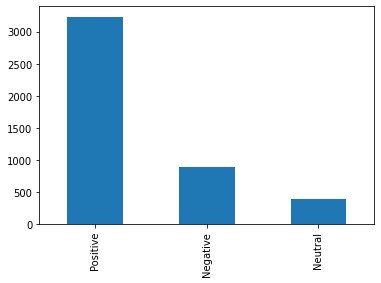

In [ ]:
# predominantly positive reviews for adhd medication
adhd_sentiment = pd.Series(adhd['Sentiment'])

adhd_sentiment_count = adhd_sentiment.value_counts()

adhd_sentiment_count.plot(kind='bar')

In [ ]:
# number of positive reviews for each brand
adhd_positive=adhd[(adhd['Sentiment']=='Positive')] 
adhd_positive['drugName'].value_counts()

Lisdexamfetamine                       417
Vyvanse                                410
Amphetamine / dextroamphetamine        367
Methylphenidate                        366
Adderall                               192
Concerta                               174
Atomoxetine                            133
Strattera                              129
Adderall XR                            118
Dexmethylphenidate                      92
Dextroamphetamine                       86
Guanfacine                              84
Intuniv                                 62
Ritalin                                 57
Bupropion                               54
Daytrana                                51
Dexedrine                               50
Focalin XR                              48
Focalin                                 36
Amphetamine                             32
Clonidine                               30
Methamphetamine                         25
Metadate CD                             22
Desoxyn    

In [ ]:
# brands with the most to least total neutral/negative reviews
adhd_neutral_negative=adhd[(adhd['Sentiment']=='Neutral') | (adhd['Sentiment']=='Negative')] 
adhd_neutral_negative['drugName'].value_counts()

Atomoxetine                        152
Strattera                          148
Methylphenidate                    147
Lisdexamfetamine                   131
Vyvanse                            130
Amphetamine / dextroamphetamine     89
Concerta                            83
Guanfacine                          72
Intuniv                             45
Adderall                            35
Dexmethylphenidate                  28
Amphetamine                         22
Adderall XR                         21
Ritalin                             19
Bupropion                           18
Focalin                             17
Metadate CD                         12
Adzenys XR-ODT                      10
Mydayis                             10
Daytrana                            10
Focalin XR                          10
Quillivant XR                        9
Dextroamphetamine                    8
Dexedrine                            7
Evekeo                               6
Clonidine                

In [ ]:
from sklearn.model_selection import train_test_split

X = adhd['review']
y = adhd['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

In [ ]:
tokenizer = nltk.RegexpTokenizer(r'[a-zA-Z]{3,}')

count_vect = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1), tokenizer=tokenizer.tokenize)
X_train_converted = count_vect.fit_transform(X_train)
X_test_converted = count_vect.transform(X_test)

X_train_converted_df = pd.DataFrame(X_train_converted.toarray(), columns = count_vect.get_feature_names_out())
X_train_converted_df.head(10)

aadd  abilify  abilities  ability  abit  able  ablitly  abnormal  aboring  \
0     0        0          0        0     0     0        0         0        0   
1     0        0          0        0     0     0        0         0        0   
2     0        0          0        0     0     0        0         0        0   
3     0        0          0        0     0     1        0         0        0   
4     0        0          0        0     0     0        0         0        0   
5     0        0          0        0     0     0        0         0        0   
6     0        0          0        0     0     0        0         0        0   
7     0        0          0        0     0     0        0         0        0   
8     0        0          0        0     0     0        0         0        0   
9     0        0          0        0     0     0        0         0        0   

   abrasions  ...  zombied  zombies  zombified  zombish  zone  zoned  zones  \
0          0  ...        0        0          0        0     0      0      0   
1          0  ...        0        0          0        0     0      0      0   
2          0  ...        0        0          0        0     0      0      0   
3          0  ...        0        0          0        0     0      0      0   
4          0  ...        0        0          0        0     0      0      0   
5          0  ...        0        0          0        0     0      0      0   
6          0  ...        0        0          0        0     0      0      0   
7          0  ...        0        0          0        0     0      0      0   
8          0  ...        0        0          0        0     0      0      0   
9          0  ...        0        0          0        0     0      0      0   

   zoning  zoplicone  zyprexa  
0       0          0        0  
1       0          0        0  
2       0          0        0  
3       0          0        0  
4       0          0        0  
5       0          0        0  
6       0          0        0  
7       0          0        0  
8       0          0        0  
9       0          0        0  

[10 rows x 6771 columns]

In [ ]:
corpus = adhd['review'].array
tfidf_vect = TfidfVectorizer(tokenizer = tokenizer.tokenize, stop_words='english', ngram_range = (1,1))
TF_IDF = tfidf_vect.fit_transform(corpus)
TF_IDF_df = pd.DataFrame(TF_IDF.toarray(), columns = tfidf_vect.get_feature_names_out())
TF_IDF_df

aadd  abilify  abilities  ability  abit      able  ablitly  abnormal  \
0      0.0      0.0        0.0      0.0   0.0  0.000000      0.0       0.0   
1      0.0      0.0        0.0      0.0   0.0  0.085943      0.0       0.0   
2      0.0      0.0        0.0      0.0   0.0  0.000000      0.0       0.0   
3      0.0      0.0        0.0      0.0   0.0  0.000000      0.0       0.0   
4      0.0      0.0        0.0      0.0   0.0  0.000000      0.0       0.0   
...    ...      ...        ...      ...   ...       ...      ...       ...   
4504   0.0      0.0        0.0      0.0   0.0  0.000000      0.0       0.0   
4505   0.0      0.0        0.0      0.0   0.0  0.000000      0.0       0.0   
4506   0.0      0.0        0.0      0.0   0.0  0.000000      0.0       0.0   
4507   0.0      0.0        0.0      0.0   0.0  0.000000      0.0       0.0   
4508   0.0      0.0        0.0      0.0   0.0  0.000000      0.0       0.0   

      aboring  abrasions  ...  zombied  zombies  zombified  zombish  zone  \
0         0.0        0.0  ...      0.0      0.0        0.0      0.0   0.0   
1         0.0        0.0  ...      0.0      0.0        0.0      0.0   0.0   
2         0.0        0.0  ...      0.0      0.0        0.0      0.0   0.0   
3         0.0        0.0  ...      0.0      0.0        0.0      0.0   0.0   
4         0.0        0.0  ...      0.0      0.0        0.0      0.0   0.0   
...       ...        ...  ...      ...      ...        ...      ...   ...   
4504      0.0        0.0  ...      0.0      0.0        0.0      0.0   0.0   
4505      0.0        0.0  ...      0.0      0.0        0.0      0.0   0.0   
4506      0.0        0.0  ...      0.0      0.0        0.0      0.0   0.0   
4507      0.0        0.0  ...      0.0      0.0        0.0      0.0   0.0   
4508      0.0        0.0  ...      0.0      0.0        0.0      0.0   0.0   

      zoned  zones  zoning  zoplicone  zyprexa  
0       0.0    0.0     0.0        0.0      0.0  
1       0.0    0.0     0.0        0.0      0.0  
2       0.0    0.0     0.0        0.0      0.0  
3       0.0    0.0     0.0        0.0      0.0  
4       0.0    0.0     0.0        0.0      0.0  
...     ...    ...     ...        ...      ...  
4504    0.0    0.0     0.0        0.0      0.0  
4505    0.0    0.0     0.0        0.0      0.0  
4506    0.0    0.0     0.0        0.0      0.0  
4507    0.0    0.0     0.0        0.0      0.0  
4508    0.0    0.0     0.0        0.0      0.0  

[4509 rows x 7158 columns]

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

# accuracy tends to be better the higher the max_depth is
decision_tree_model = DecisionTreeClassifier(criterion='gini', max_depth=15)
decision_tree_model.fit(X_train_converted, y_train)

predicted= decision_tree_model.predict(X_test_converted)
print("Decision Tree Accuracy:", str(round(metrics.accuracy_score(y_test, predicted)*100,2))+"%")

Decision Tree Accuracy: 80.27%


In [ ]:
from sklearn.tree import export_text
tree_rules = export_text(decision_tree_model, feature_names=count_vect.get_feature_names())
print(tree_rules)

|--- worse <= 0.50
|   |--- life <= 0.50
|   |   |--- depressed <= 0.50
|   |   |   |--- crying <= 0.50
|   |   |   |   |--- tired <= 0.50
|   |   |   |   |   |--- developed <= 0.50
|   |   |   |   |   |   |--- worst <= 0.50
|   |   |   |   |   |   |   |--- angry <= 0.50
|   |   |   |   |   |   |   |   |--- years <= 0.50
|   |   |   |   |   |   |   |   |   |--- stopped <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- school <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |   |--- school >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |--- stopped >  0.50
|   |   |   |   |   |   |   |   |   |   |--- best <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |   |--- best >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: Positive
|   |   |   |   |   |   |   |  

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# When people use "little", "times", "hit", "care", "zombie", "anxiety", "sleeping", and "didn't", they tend to be upset.
# Baseed on these words, people's complaints seem to be that the ADHD medication didn't help, may cause anxiety, or
# puts them in a zombie-like state, which usually happens when the dosage is too high, resulting in putting the patient
# in a state of extreme hyperfocus.  It seems like the patients tend to have trouble sleeping, and these side effects
# have occurred more than once. 

# When people use "focus", "appetite", "concentration", "lately", "try", and "acting", they tend to be neutral or 
# impartial about the ADHD medication. It's likely that the medication sometimes works for them, in terms of helping
# them focus / concentrate, improving appetite, but since they left a neutral review, it's likely that it doesn't always
# work.

# When people use words like "best", "works", "terrible", "appetite", "focus", or "sleeping", they tend to be happy about
# their ADHD medication. Based on the word choice, I can infer that these people used to have trouble sleeping and focusing,
# and had a terrible appetite. However, after being on ADHD medication, it works like a charm and fixes the symptoms
# that they were experiencing before.

# Topic Modeling

In [ ]:
all_adhd_reviews = " ".join(review for review in adhd['review'])
all_adhd_reviews

'"My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. \r\nWe have tried many different medications and so far this is the most effective." "Hi all, My son who is 12 was diagnosed when he was in 2nd grade. We tried everything before medication. When we tried meds, the first one made him loose weight, fast. The second gave him a nasty tic that thankfully went away as soon as he stopped the med

In [ ]:
corpus = adhd['review'].array

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


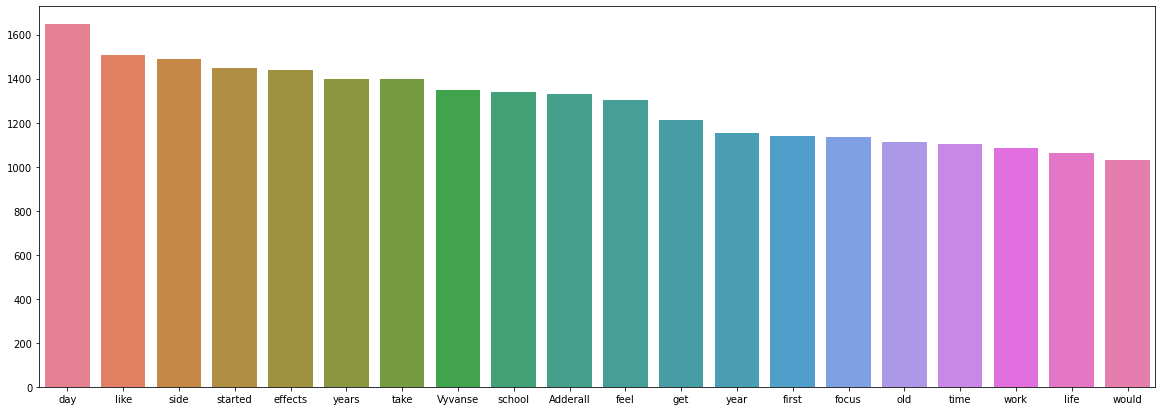

In [ ]:
import seaborn as sb

tokenizer = nltk.RegexpTokenizer(r'[a-zA-Z]{3,}')
tokens = tokenizer.tokenize(all_adhd_reviews) 
stopwordsList = stopwords.words('english')
stopwordsList.append('adhd')  # we're looking at adhd, so it's a given that it's being discussed
stopwordsList.append('taking')  # data is abt medication, so it's a given that they're talking abt taking it 
stopwordsList.append('medication')  # data is abt medication, so this word doesn't tell us much
tokens_stop = [word for word in tokens if word.lower() not in stopwordsList]
freq_dist = nltk.FreqDist(tokens_stop)
mostCommonWordList = dict(freq_dist.most_common(20))
plt.figure(figsize =(20, 7)) 
sb.barplot(list(mostCommonWordList.keys()), list(mostCommonWordList.values()), palette='husl')

In [ ]:
# It seems like people's ADHD was getting in the way of their life (ie. school or work), but based on the word frequency 
# graph, I can see that the medication has helped a lot of people. They can experience things like old times, and they 
# haven't felt like this in years. People also mentioned Vyvanse and Adderall, both of which are types of medication
# to alleviate ADHD symptoms. However, while they're not the ones with the highest number of reviews, it's likely that
# people like these two brands the most or feel the most strongly about them.

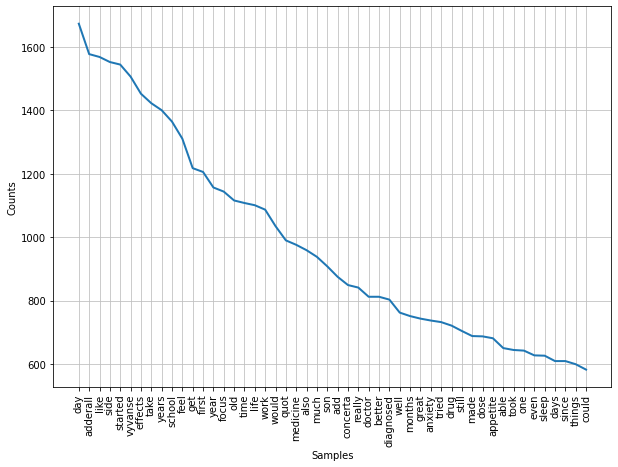

In [ ]:
freqDist = FreqDist()

for i in range (0, len(corpus)):
    reviewWordList = []
    for word in tokenizer.tokenize(corpus[i]):
        if word.lower() not in stopwordsList:
            reviewWordList.append(word.lower()) 
    
    freqDist += FreqDist(reviewWordList)
    
plt.figure(figsize =(10, 7)) 
freqDist.plot(50, cumulative=False)

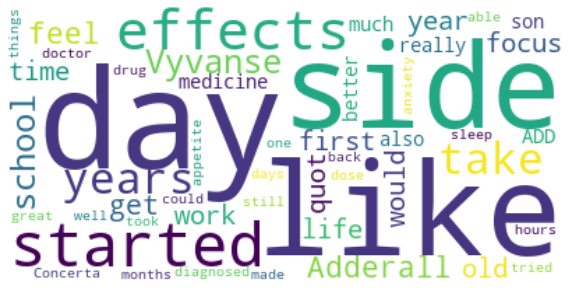

In [ ]:
from wordcloud import WordCloud

mostCommonWordList = dict(freq_dist.most_common(50))
wordcloud = WordCloud(background_color="white").generate_from_frequencies(frequencies=mostCommonWordList)

plt.figure(figsize =(10, 7)) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
tokenizer = nltk.RegexpTokenizer(r'[a-zA-Z]{3,}')

count_vect = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1), tokenizer=tokenizer.tokenize)
review_converted = count_vect.fit_transform(adhd['review'])

review_converted_df = pd.DataFrame(review_converted.toarray(), columns = count_vect.get_feature_names_out())
review_converted_df.head(5)

aadd  abilify  abilities  ability  abit  able  ablitly  abnormal  aboring  \
0     0        0          0        0     0     0        0         0        0   
1     0        0          0        0     0     1        0         0        0   
2     0        0          0        0     0     0        0         0        0   
3     0        0          0        0     0     0        0         0        0   
4     0        0          0        0     0     0        0         0        0   

   abrasions  ...  zombied  zombies  zombified  zombish  zone  zoned  zones  \
0          0  ...        0        0          0        0     0      0      0   
1          0  ...        0        0          0        0     0      0      0   
2          0  ...        0        0          0        0     0      0      0   
3          0  ...        0        0          0        0     0      0      0   
4          0  ...        0        0          0        0     0      0      0   

   zoning  zoplicone  zyprexa  
0       0          0        0  
1       0          0        0  
2       0          0        0  
3       0          0        0  
4       0          0        0  

[5 rows x 7158 columns]

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=5, max_iter=10) #max_iter=5
lda.fit(review_converted)

LatentDirichletAllocation(n_components=5)

In [ ]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [ ]:
# can use translator package to convert to eng and interpret from there
print("Topics found via LDA:")
print_topics(lda, count_vect, 10)

Topics found via LDA:

Topic #0:
adhd vyvanse adderall medication day son medicine effects years anxiety

Topic #1:
feel taking like work adderall day don focus medication just

Topic #2:
started school adhd son year old taking just like vyvanse

Topic #3:
adderall effects like taking quot life day medication adhd feel

Topic #4:
years life vyvanse school adhd quot day taking concerta old
